In [1]:
import numpy as np
import hashlib
import math
import pandas as pd 
import matplotlib.pyplot as plt
import random
import re
import string
from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
import spacy


In times where even [facebook goes down](https://www.theguardian.com/technology/2021/oct/04/facebook-instagram-whatsapp-outage-what-to-do), books are our reliable companions. For true book lovers, it's hard to resist the urge to buy huge piles to add to our "To read" lists. But how to know which is the right book to buy?

In any online book store, you can find hundreds of reviews. You also have [goodreads](https://www.goodreads.com/), [book riot](https://bookriot.com/), and many others.



The only problem is, more and more, is hard to navigate through the hundreds and hundreds of reviews, and even if you did have the time, a huge amount is completely unhelpful. Not to mention the ones that definitely seem posted by bots.

<img src="media/fake-reviews.jpg" width="50%" />


## Q1 - Baseline 

To cope with all of this, you set out to create a model to look for the most helpful reviews for you. You find a dataset online providing reviews and helpfulness metrics and start there.

Load the dataset and check its structure:


In [2]:
def load_data():
    """
    Loads dataframe of reviews helpfulness 
    """
    df = pd.read_csv('datasets/book_review_helpfulness.csv')
    df.head()
    return df

df = load_data()
df.head()


,helpfulness,reviewText
0,1,Old Bear; Kevin Henkes (2008) Harper Collins C...
1,0,This book is based on the sad truth of the sta...
2,1,When Lara's grandmother's ghost begins bashing...
3,1,"Charlotte Simmons is the definitive, classic A..."
4,0,Much too stereotypical for my tastes and the s...


### Q1.a)

First thing you decide is to extract features from the reviews. So you start working out how to do it. First you think it may be good to preprocess the text a bit, so you look into a few options. You end up converging into the following:

- tokenizing the text, using WordPunctTokenizer
- lowercasing the text

You then decide to feed this into a CountVectorizer. Implement this function below: 
 

In [3]:
def extract_features(X_train, X_test):
    """Converts the provided text training and test data into 
    feature counts. Additionally, returns the used vectorizer, 
    the processed dataframes and the number of features extracted
    
    Parameters:
        X_train: dataframe: training data, containing a "reviewText" column
        X_test: dataframe: test data, containing a "reviewText" column
    
    Returns:
        vectorizer: used count vectorizer 
        num_features: vectorizer actual number of features, for sanity check
        X_train_vec: processed training features
        X_test_vec: processed test features
    """
    
    # YOUR CODE HERE
    
    preprocessor = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc.lower()))
    
    X_train['reviewText'] = X_train['reviewText'].map(preprocessor)
    X_test['reviewText'] = X_test['reviewText'].map(preprocessor)
    
    vectorizer = CountVectorizer()
    
    X_train_vec = vectorizer.fit_transform(X_train.reviewText)
    X_test_vec = vectorizer.transform(X_test.reviewText)
    
    num_features = X_train_vec.shape[1]
    
    return vectorizer, num_features, X_train_vec, X_test_vec


In [4]:
df = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['helpfulness']), 
    df['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test)
assert math.isclose(np.sum(X_train_vec.todense()[12, :]), 284)
assert math.isclose(np.sum(X_train_vec.todense()[300, :]), 157)
assert math.isclose(np.sum(X_train_vec.todense()[1411, :]), 222)

assert num_features == 44103



_For the next exercises we'll provide you a different version of the preprocessed data._

_Load the preprocessed dataset provided in the file_


In [5]:
def load_preprocessed_data():
    """
    Loads dataframe of preprocessed helpfulness review 
    """
    preprocessed_df = pd.read_csv('datasets/book_review_helpfulness_preprocessed.csv')
    preprocessed_df.head()
    return preprocessed_df

df_preprocessed = load_preprocessed_data()
df_preprocessed.head()


,helpfulness,reviewText
0,1,old bear kevin henkes harper collins childrenl...
1,0,book based sad truth state country humor berni...
2,1,lara grandmother ghost begins bashing guests f...
3,1,charlotte simmons definitive classic american ...
4,0,much stereotypical tastes storyline unbelievab...


### Q1.b)

You now want to use your newly found features to build a baseline. Create a function that receives your vectorized instances and train a naïve bayes model.

First we'll start by defining a function to obtain precision and recall:

In [6]:
def get_precision_recall(y_test, y_pred):
    """Returns the precision and recall of the helpfulness class (label = 1)
    
    Parameters:
        y_test (Series): Labels corresponding to X_test
        y_pred (Series): Predictions corresponding to X_test

    Returns:
        precision (float): The precision score of the helpfulness class (1) on the test data
        recall (float): The recall score of the helpfulness class (1) on the test data
    """

    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    return precision, recall
    


Implement below the function ot train a naive bayes model and use the precision_recall function to return these metrics over the test set:

In [7]:
def train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test):
    """Returns a fitted Multinomial Naive Bayes model, the predictions on the test set
    and the precision and recall scores for these predictions
    
    Parameters:
        X_train_vec (Series): Vectorized text data for training
        y_train (Series): Labels corresponding to X_train
        X_test_vec (Series): Vectorized text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        clf (MultinomialNB): MultinomialNB classifier fitted to the feature-selected training data
        y_pred (Series): The predictions computed with our classifier
        precision (float): The precision score of the helpfulness class (1) on the test data
        recall (float): The recall score of the helpfulness class (1) on the test data
    """
    
    # YOUR CODE HERE
    clf = MultinomialNB()
    
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    
    precision = precision_score(y_true = y_test, y_pred=y_pred)
    recall = recall_score(y_true = y_test, y_pred=y_pred)

    return clf, y_pred, precision, recall

Test your model below:

In [8]:
df = load_data()

cv = CountVectorizer()

X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['helpfulness'], test_size=0.2, random_state=42)

cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
assert math.isclose(precision, 0.6305625524769102)
assert math.isclose(recall, 0.689623507805326)


X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['helpfulness'], test_size=0.5, random_state=42)

cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
assert math.isclose(precision, 0.6058282208588958)
assert math.isclose(recall, 0.7391467065868264)

df_prep = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(df_prep['reviewText'], df_prep['helpfulness'], test_size=0.2, random_state=42)

cv = CountVectorizer()
cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)

assert math.isclose(precision, 0.6260032102728732), precision
assert math.isclose(recall, 0.7162534435261708), recall



Now run the two functions you built put together and check your baseline scores:

In [9]:
df = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['helpfulness']), 
    df['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test)
clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)

print(f"Baseline precision: {precision}")
print(f"Baseline recall: {recall}")


Baseline precision: 0.6274292059966685
Baseline recall: 0.7040498442367601


_We'll also run with our own provided preprocessed data so you have a base of comparison._

In [10]:
df_prep = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_prep['reviewText'], 
    df_prep['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

cv = CountVectorizer()
cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

print(f"Number of features: {len(cv.vocabulary_)}")

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)

print(f"Baseline precision: {precision}")
print(f"Baseline recall: {recall}")


Number of features: 43290
Baseline precision: 0.6101159114857745
Baseline recall: 0.7214953271028037


As we'll use the provided version on your exercises consider this as the baseline:

* Baseline precision: 0.6101159114857745
* Baseline recall: 0.7214953271028037


## Q2) Feature analysis and selection

Those are not bad results to start with, but as you've learned about features selection you want to try it out. After all, 43 thousand feature is still a pretty big number. 




You start by using model based feature selection. For that purpose, you want to use the capability of TF-IDF/CountVectorizer to select the features to use. 


### Q2.a)

Fit a TF-IDF vectorizer with a specific number of features. Note that the features will be selected based on term frequency, so whatever vocabulary used will be based on the term count. Return these features sorted inverse document frequency, the other measure used by TF-IDF - as you've seen in the learning notebooks, a measure of whether a term is common or rare in the documents.

Create that function below:
* train a tf-idf vectorizer on the provided train data (passing a parameter to define the maximum number of features to use)
* return its features sorted by their inverse document frequency (in descending order). 

**Note**: In case of tie, this is, if several features have the same IDF score, the features should be sorted by alphabetical order.


In [11]:
def get_tfidf_ngrams_sorted_by_idf(X_train, top_features=30):
    """Fits a TfidfVectorizer and returns its features sorted by 
    idf score
    
    Parameters:
        X_train (Series): Vectorized text data for training
        top_features: Top features to use 
    
    Returns:
        vectorizer: used tf-idf vectorizer 
        ngrams_sorted (list): The ngrams of fitted_vectorizer sorted in descending order
                              by their idf score. In case of tie, the features should be sorted 
                              by alphabetical order
    """
    
    # YOUR CODE HERE
    
    vectorizer = TfidfVectorizer(max_features=top_features)
    
    vectorizer.fit_transform(X_train)

    ngrams_sorted = vectorizer.get_feature_names()

    mydict = {}
    for feature in vectorizer.get_feature_names():
        mydict[feature] = vectorizer.idf_[vectorizer.vocabulary_[feature]]
    
       
    ngrams_sorted = [ x[0] for x in sorted(mydict.items(), key=lambda x: x[1], reverse=True) ]

    return vectorizer, ngrams_sorted


In [12]:
df_preprocessed = load_preprocessed_data()

vectorizer, sorted_n_grams = get_tfidf_ngrams_sorted_by_idf(df_preprocessed['reviewText'], top_features=100)
assert hashlib.sha256(sorted_n_grams[12].encode()).hexdigest() == "bfa062de040f55a15ce910800757061ec3d2fc31d6b7c72d9fa02b75a9ad1133"

vectorizer, sorted_n_grams = get_tfidf_ngrams_sorted_by_idf(df_preprocessed['reviewText'], top_features=100)
assert hashlib.sha256(sorted_n_grams[41].encode()).hexdigest() == "47951833ecf6211793c07d246c29b2314abdd784d806d2253c5723dc5e3b0d74"

vectorizer, sorted_n_grams = get_tfidf_ngrams_sorted_by_idf(df_preprocessed['reviewText'], top_features=100)
assert hashlib.sha256(sorted_n_grams[76].encode()).hexdigest() == "686f746a95b6f836d7d70567c302c3f9ebb5ee0def3d1220ee9d4e9f34f5e131"


Check the features with top inverse document frequency in your vectorizer:

In [13]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

#show most specifc 30 features of the 100 selected features
vectorizer, sorted_n_grams = get_tfidf_ngrams_sorted_by_idf(X_train, top_features=1000)

print(sorted_n_grams[:30])


['ben', 'jane', 'empire', 'brown', 'henry', 'mary', 'peter', 'france', 'joe', 'economic', 'vampire', 'jesus', 'harry', 'film', 'scientific', 'animals', 'french', 'queen', 'philosophy', 'music', 'army', 'civil', 'club', 'george', 'market', 'theory', 'team', 'conflict', 'london', 'nation']


As we're only seeing the top IDF features, they tend to be more specific words you would find only in a subset of documents. But in general all of these features are not surprising in the context of books. 

### Q2.b)

Finally we want to see how this behaves in comparison with our baseline. Use the functions you have seen above to try out different values of features (50, 100, 500, 1000, 2000, 5000 and 10000) in the training of a Multinomial Naive Bayes. Check the precision and recall of each run and store it on a list:


In [14]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

# For the following values: 50, 100, 500, 1000, 2000, 5000 and 10000
# 1. Fit a TF-IDF limiting its features 
# 2. Train a Naive Bayes model
# 3. Obtain precision and recall
# 4. Store the lists of feature length, precision and recall values 

feature_lengths = []
precisions_values = []
recall_values = []

# YOUR CODE HERE
for k in [50, 100, 500, 1000, 2000, 5000, 10000]:
    vectorizer, ngrams_sorted = get_tfidf_ngrams_sorted_by_idf(X_train, k)
    
    X_train_vec = vectorizer.transform(X_train) 
    X_test_vec = vectorizer.transform(X_test)
    
    clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
    
    feature_lengths.append(k)
    precisions_values.append(precision)
    recall_values.append(recall)

In [15]:

assert len(feature_lengths) == len(precisions_values) == len(recall_values) == 7

assert math.isclose(precisions_values[4], 0.6114101184068891)
assert math.isclose(recall_values[5], 0.7171339563862928)

assert math.isclose(np.sum(precisions_values), 4.170958590158336)
assert math.isclose(np.sum(recall_values), 5.242990654205607)


Look at the precision, recall variation of each and answer the questions below:

In [16]:
for n_features, precision, recall in zip(feature_lengths, precisions_values, recall_values):
    print(f"Number of features: {n_features}")
    print(f"Precision: {precision}")    
    print(f"Recall: {recall}")
    print("==============================")


Number of features: 50
Precision: 0.5735359856951274
Recall: 0.7993769470404984
Number of features: 100
Precision: 0.5740824648844586
Recall: 0.7894080996884735
Number of features: 500
Precision: 0.5925
Recall: 0.7383177570093458
Number of features: 1000
Precision: 0.6041666666666666
Recall: 0.7227414330218068
Number of features: 2000
Precision: 0.6114101184068891
Recall: 0.7077881619937695
Number of features: 5000
Precision: 0.6132125732551944
Recall: 0.7171339563862928
Number of features: 10000
Precision: 0.60205078125
Recall: 0.7682242990654206


**Q2.b.i)** Which number of feature yielded the **highest precision**?

In [17]:
num_features_higher_precision = 5000 # numeric value
# YOUR CODE HERE


In [18]:
assert hashlib.sha256(bytes(num_features_higher_precision)).hexdigest() == \
    "7ca5bd879f393d9dd05b14f38add9c0fc6b67928f7f2d261b2e47a32ee8219e3"


**Q2.b.ii)** Which number of feature yielded the **highest recall**?

In [19]:
num_features_higher_recall = 50 # numeric value
# YOUR CODE HERE

In [20]:
assert hashlib.sha256(bytes(num_features_higher_recall)).hexdigest() == \
    "cc2786e1f9910a9d811400edcddaf7075195f7a16b216dcbefba3bc7c4f2ae51"


**Q2.b.iii)** Which number of feature yielded the **highest F1-score**?

In [21]:
num_features_higher_f1 = 10000 # numeric value
# YOUR CODE HERE

In [22]:
assert hashlib.sha256(bytes(num_features_higher_f1)).hexdigest() == \
    "95b532cc4381affdff0d956e12520a04129ed49d37e154228368fe5621f0b9a2"


**Q2.b.iv)** Knowing we won't be able to read that many reviews, but we want to make sure the ones we do read are helpfull, which number of features would you choose? 

In [23]:
choice_model = "precision"  # one of "precision" or "recall"  or "f1-score"
# YOUR CODE HERE

In [24]:
assert hashlib.sha256(choice_model.encode()).hexdigest() == \
    "68c2f9ee314749c05c96df0cad305b0972506d78bb9b23c942cf805b274236c6"



### Q2.c)

You also heard about Chi squared, another method that will try to find the relevance of features and select the best ones based on it.

<img src="media/chi-squared-not-sure.jpg" width="40%" />

You decide to implement a function to run chi-squared over your vectorizer and return the selected features.

**Note**: In this case, don't limit CountVectorizer/TfidfVectorizer to any number of features

In [25]:
def extract_features_chi2(X_train, y_train, top_features=100, vectorizer_type="count"):
    """Converts the provided text training data into TF-IDF feature counts. 
    Additionally, selects the best features with chi squared method and returns
    the sorted ngrams
    
    Parameters:
        X_train: training data
        y_train: training labels
        top_features: maximum number of features to use
        vectorizer_type: type of vectorizer to use ("count" or "tfidf")

    Returns:
        vectorizer: used tf-idf vectorizer 
        ch2: used feature selector
        X_train_ch2: transformed vector after feature selection
        ngrams_sorted (list): The top features of fitted_vectorizer sorted in ascending order
                              by their chi squared score
    """
    
    # YOUR CODE HERE
    
    if vectorizer_type == "count":
        vectorizer = CountVectorizer()
    else:
        vectorizer = TfidfVectorizer()

    X_train_vec = vectorizer.fit_transform(X_train)

    feature_names = vectorizer.get_feature_names()
    
    ch2 = SelectKBest(chi2, k=top_features)
    X_train_ch2 = ch2.fit_transform(X_train_vec, y_train)
    
    mydict = {}
    for feature_index in ch2.get_support(indices=True):
        mydict[feature_names[feature_index]] = ch2.scores_[feature_index]
       
    ngrams_sorted = [ x[0] for x in sorted(mydict.items(), key=lambda x: x[1], reverse=True) ]

    return vectorizer, ch2, X_train_ch2, ngrams_sorted

In [26]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer_ch2, ch2, X_train_ch2, most_important_features = extract_features_chi2(X_train, y_train, vectorizer_type="tfidf")
assert math.isclose(np.sum(X_train_ch2.todense()[12, :]), 0.30615842862660636)
assert ch2.k == 100

vectorizer_ch2, ch2, X_train_ch2, most_important_features = extract_features_chi2(X_train, y_train, vectorizer_type="tfidf", top_features=123)
assert math.isclose(np.sum(X_train_ch2.todense()[:, 122]), 33.74087286012022)
assert ch2.k == 123


vectorizer_ch2, ch2, X_train_ch2, most_important_features = extract_features_chi2(X_train, y_train, vectorizer_type="count")
assert math.isclose(np.sum(X_train_ch2.todense()[12, :]), 26), np.sum(X_train_ch2.todense()[12, :])
assert ch2.k == 100

vectorizer_ch2, ch2, X_train_ch2, most_important_features  = extract_features_chi2(X_train, y_train, vectorizer_type="count", top_features=123)
assert math.isclose(np.sum(X_train_ch2.todense()[:, 122]), 734)
assert ch2.k == 123



Let's apply our extractor with 30 features and check them out:

In [27]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer_ch2, ch2, X_train_ch2, most_important_features  = extract_features_chi2(X_train, y_train, top_features=30)

most_important_features

['book',
 'story',
 'one',
 'life',
 'quot',
 'also',
 'world',
 'well',
 'first',
 'people',
 'novel',
 'time',
 'years',
 'even',
 'reader',
 'many',
 'two',
 'mother',
 'make',
 'young',
 'new',
 'like',
 'much',
 'work',
 'find',
 'stories',
 'may',
 'home',
 'family',
 'us']

We can also see how often each of the features selected appears in the reviews:

In [28]:
for feature in most_important_features:
    print('Documents that contains the word(s) "%s"' % feature)
    print('----')
    docs = X_train.str.lower().str.contains(feature)
    print(str(y_train[docs].value_counts()) + '\n\n')

Documents that contains the word(s) "book"
----
1    3063
0    2507
Name: helpfulness, dtype: int64


Documents that contains the word(s) "story"
----
1    1705
0    1164
Name: helpfulness, dtype: int64


Documents that contains the word(s) "one"
----
1    2537
0    1710
Name: helpfulness, dtype: int64


Documents that contains the word(s) "life"
----
1    1045
0     565
Name: helpfulness, dtype: int64


Documents that contains the word(s) "quot"
----
1    272
0    134
Name: helpfulness, dtype: int64


Documents that contains the word(s) "also"
----
1    937
0    522
Name: helpfulness, dtype: int64


Documents that contains the word(s) "world"
----
1    745
0    375
Name: helpfulness, dtype: int64


Documents that contains the word(s) "well"
----
1    1224
0     710
Name: helpfulness, dtype: int64


Documents that contains the word(s) "first"
----
1    1079
0     634
Name: helpfulness, dtype: int64


Documents that contains the word(s) "people"
----
1    839
0    487
Name: helpfulness,

It seems that most features selected as relevant are slightly more attached to the "helpful" class (1).

Now let's see how that translates in terms of model training. Repeat the procedure you done above to check the feature selection scores. Do that using the function you just created with count vectorizer and chi-squared:


In [29]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

# For the following values: 50, 100, 500, 1000, 2000, 5000 and 10000
# 1. Use a count vectorizer and ch2 feature selection with the give number of features 
# 2. Train a Naive Bayes model
# 3. Obtain precision and recall
# 4. Store the lists of feature length, precision and recall values 

feature_lengths = []
precisions_values = []
recall_values = []

# YOUR CODE HERE
for k in [50, 100, 500, 1000, 2000, 5000, 10000]:
    vectorizer, ch2, X_train_ch2, ngrams_sorted = extract_features_chi2(X_train, y_train, k)
    
    #X_train_vec = vectorizer.transform(X_train)
    X_test_ch2 = ch2.transform(vectorizer.transform(X_test))
    
    clf, y_pred, precision, recall = train_model_naive_bayes(X_train_ch2, y_train, X_test_ch2, y_test)
    
    feature_lengths.append(k)
    precisions_values.append(precision)
    recall_values.append(recall)

In [30]:

assert len(feature_lengths) == len(precisions_values) == len(recall_values) == 7

assert math.isclose(precisions_values[4], 0.649458784346378)
assert math.isclose(recall_values[5], 0.49221183800623053)

assert math.isclose(np.sum(precisions_values), 4.416826519514508)
assert math.isclose(np.sum(recall_values), 3.5514018691588785)


Finally, check the scores:

In [31]:
for n_features, precision, recall in zip(feature_lengths, precisions_values, recall_values):
    print(f"Number of features: {n_features}")
    print(f"Precision: {precision}")    
    print(f"Recall: {recall}")
    print("==============================")


Number of features: 50
Precision: 0.5874079035498996
Recall: 0.5464174454828661
Number of features: 100
Precision: 0.6043795620437956
Recall: 0.5158878504672897
Number of features: 500
Precision: 0.630016051364366
Recall: 0.48909657320872274
Number of features: 1000
Precision: 0.6371753246753247
Recall: 0.48909657320872274
Number of features: 2000
Precision: 0.649458784346378
Recall: 0.48598130841121495
Number of features: 5000
Precision: 0.661641541038526
Recall: 0.49221183800623053
Number of features: 10000
Precision: 0.6467473524962178
Recall: 0.5327102803738317


In this case, we are able to raise precision (check the values for 5000 features) even though we sacrifice recall.


## Q3.

Now let's move on to more complex methods. In the previous methods, the selection is based on the actual n-grams, so we are limited to the information each feature brings separately. We will now try PCA, which will try to find the principal components of our vectorized representation 

Write a function that computes PCA on top of a CountVectorizer. Additionally, train a Support Vector Classifier on top of the PCA output.

**To avoid using up too much memory, and as we'll use dense matrices, please use a max_features value of 5000 in the vectorizer**


In [32]:
def train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42):
    """Returns a fitted TfidfVectorizer, the truncated svd used, a support vector classifier
    and the test predictions computed with these
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test
        num_features (int): maximum number of features to use
        seed (int): Seed to use for random state

    Returns:
        vectorizer (CountVectorizer): CountVectorizer, fitted to X_train
        pca (PCA): PCA with provided number of features as components
        clf (SVC): SVC classifier fitted to the feature-selected training data
        y_pred (Series): The predictions computed with our classifier
    """
    # YOUR CODE HERE
    
    vectorizer = CountVectorizer(max_features=5000)
    vectorizer.fit(X_train)
    
    X_train_vec = vectorizer.transform(X_train).toarray()
    X_test_vec = vectorizer.transform(X_test).toarray()
    data_var = np.var(X_train_vec, axis=0).sum()
    
    
    pca = PCA(n_components=num_features, random_state=seed)
    pca.fit(X_train_vec)

    X_train_pca = pca.transform(X_train_vec)
    X_test_pca = pca.transform(X_test_vec)
    
    
    clf =  SVC(random_state=seed)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    
    explained_variance = 1.0*np.var(X_train_pca, axis=0).sum() / data_var
    
    return vectorizer, pca, clf, y_pred, explained_variance

In [33]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer, pca, clf, y_pred_30, variance_30 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=30, seed=42)
print("----- Computed PCA for 30 features -----\n")
assert np.mean(y_pred_30) == 0.5516666666666666
assert np.sum(y_pred_30) == 1655
assert pca.n_components == 30
assert vectorizer.get_feature_names()[4424] == 'teaching'

vectorizer, pca, clf, y_pred_50, variance_50 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=50, seed=42)
print("----- Computed PCA for 50 features -----\n")
assert np.mean(y_pred_50) == 0.5416666666666666
assert np.sum(y_pred_50) == 1625
assert pca.n_components == 50
assert vectorizer.get_feature_names()[4424] == 'teaching'

vectorizer, pca, clf, y_pred_100, variance_100 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42)
print("----- Computed PCA for 100 features -----\n")
assert np.mean(y_pred_100) == 0.544
assert np.sum(y_pred_100) == 1632
assert pca.n_components == 100
assert vectorizer.get_feature_names()[4424] == 'teaching'


----- Computed PCA for 30 features -----

----- Computed PCA for 50 features -----

----- Computed PCA for 100 features -----



We can obtain the precision and recall as before and compare with the previous results:

In [34]:
precision, recall = get_precision_recall(y_test, y_pred_30)     
print("\nPredictions with 30 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_50)      
print("\nPredictions with 50 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

precision, recall = get_precision_recall(y_test, y_pred_100)     
print("\nPredictions with 100 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))


Predictions with 30 features: 
Precision: 0.656797583081571
Recall: 0.6772585669781932

Predictions with 50 features: 
Precision: 0.6646153846153846
Recall: 0.6728971962616822

Predictions with 100 features: 
Precision: 0.6611519607843137
Recall: 0.6722741433021807


Nice! We keep the high precision of other feature selection methods but with much higher recall!

## Q4.

Now we'll change gears a bit and look into word vectors. In Learning Notebook 3 we told you that word vectors can be visualized after being projected into 2D space, and we showed you this diagram:

<img src="./media/word-vectors-projection.png" width="600">

Now we'll try to combine what you've learned about word embeddings and PCA to make our own visualization!

In [35]:
# load word embeddings

nlp = spacy.load('en_core_web_md')

### Q4.a)

First, to get comfortable with spacy, get the vector for the word "book" 

In [36]:
book_vector = nlp('book').vector
# YOUR CODE HERE

In [37]:
assert math.isclose(book_vector.sum(), -8.673375, abs_tol=0.00001)
assert book_vector.shape[0] == 300

### Q4.b) 

Next, write a function that uses sklearn's PCA to reduce our vectors to a convenient number of dimensions for plotting. The function should return the reduced dimension word vectors.

In [38]:
def reduce_word_vecs(vectors, random_state):
    """
    Returns PCA-reduced word vectors of the input vectors for plotting
    
    Parameters:
        vectors (np.array): Word vectors to be reduced
        random_state (int): random state to use in PCA

    Returns:
        reduced_vecs (np.array): Word vectors reduced to the number of dimensions
                                 suitable for plotting with given random_state
    """
    # YOUR CODE HERE
    pca = PCA(n_components=2, random_state=random_state)
    pca.fit(vectors)
    reduced_vecs = pca.transform(vectors)

    return reduced_vecs

In [39]:
test_vectors = np.array([[0.1, 0.2, 0.3, 0.4], [0.3, 0.5, 0.1, 0.7], [0.8, 0.6, 0.2, 0.4]])
reduced_vecs = reduce_word_vecs(test_vectors, random_state=42)

assert reduced_vecs.shape == (3,2)
assert math.isclose(reduced_vecs[1][1], 0.24736592153367926)
assert math.isclose(reduced_vecs[2][0], 0.43388622222454437)

Now, we'll create an array of ~75,000 of spacy's word vectors and use your PCA function to reduce them. If you're curious about using the full amount of word vectors, you can change the code to iterate over all vocab words - `list(nlp.vocab.strings)` - instead of our own `vocab_strings`, but beware it will use a lot of memory!

We'll also set a list of words that we'll plot later and force our set of vectors to include these.

In [40]:
words_to_plot = ['banana', 'pineapple', 'mango', 'red', 'blue', 'yellow', 'woman', 'man', 'child', 'playing',
                 'reading', 'studying', 'nintendo', 'sony', 'xbox', 'sad', 'angry', 'bored']

In [41]:
with open('datasets/word_subset.txt') as fwords:
    vocab_strings = fwords.read().splitlines()

full_vocab_vecs = []
for tok in vocab_strings:
    full_vocab_vecs.append(nlp.vocab.get_vector(tok))

vocab_array = np.array(full_vocab_vecs)

In [42]:
print('Word vectors shape pre-PCA: {}'.format(vocab_array.shape))

full_vocab_reduced = reduce_word_vecs(vocab_array, random_state=42)

print('Word vectors shape after PCA: {}'.format(full_vocab_reduced.shape))

Word vectors shape pre-PCA: (103202, 300)
Word vectors shape after PCA: (103202, 2)


In [43]:
assert math.isclose(full_vocab_reduced[100][0], -3.0880196, abs_tol=0.00001)
assert math.isclose(full_vocab_reduced[9999][0], -0.9480563, abs_tol=0.00001)

### Q4.c)

Time to plot! For this, we'll limit the visualized words to a small subset.

In [44]:
coords = []
for word in words_to_plot:
    idx = vocab_strings.index(word)
    coords.append(full_vocab_reduced[idx])

coords_array = np.array(coords)

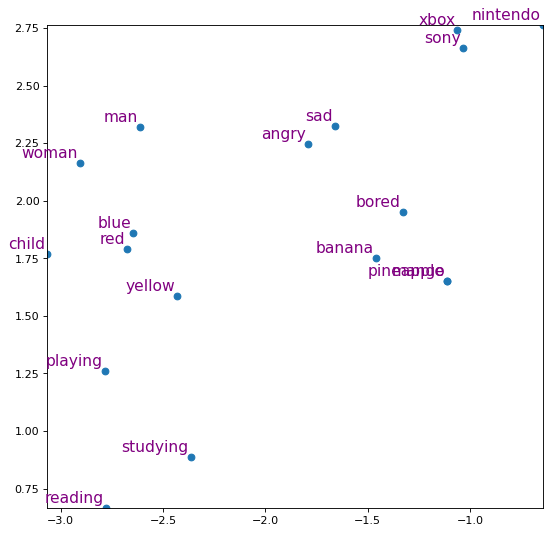

In [45]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.xlim(min([x for x in coords_array[:,0]]), max([x for x in coords_array[:,0]]))
plt.ylim(min([y for y in coords_array[:,1]]), max([y for y in coords_array[:,1]]))
plt.scatter(coords_array[:,0], coords_array[:,1])

for item, x, y in zip(words_to_plot, coords_array[:,0], coords_array[:,1]):
    plt.annotate(item, xy=(x, y), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='purple', fontsize=14 )
plt.show()

The PCA seems to have worked! In the diagram we can see similar types of words closer together. But of course, take these visualizations with a grain of salt because it is practically impossible to preserve all distances in a high dimensional space in just 2 dimensions.

### Q4.d) 

As a final exercise, we'll look at some word similarities.

Write a function that returns the next closest word in terms of cosine similarity to a given word. If there are multiple words with the same highest similarity, return all of them.

Hint: you can use the already-imported `cosine_similarity` function from sklearn to compute cosine similarity.

In [46]:
def closest_word(input_word, words_in_vocab, word_vectors):
    '''Returns a list of the closest word or words to the input word, based on cosine similarities
       of the word vectors given
    
    Parameters:
        input_word (string): Search for the closest words to this word
        words_in_vocab (list): Vocabulary associated with the vectors in word_vectors
        word_vectors (np.array): Word vectors associated with the strings in words_in_vocab

    Returns:
        closest_words_list (list): List of strings containing the closest word or words to
                                   input_word, based on cosine similarities of the word_vectors
    '''
    # YOUR CODE HERE
    
    #for word in words_in_vocab:
    index = words_in_vocab.index(input_word)
    similarities = cosine_similarity(word_vectors)[index]

    current_simil = 0
    current_index = -1
    for i in range(len(similarities)):
        if i != index and similarities[i] > current_simil:
            current_simil = similarities[i]
            current_index = i
        
    closest_words_list = [ words_in_vocab[current_index] ]
        
    return closest_words_list

In [47]:
assert(hashlib.sha256(closest_word('nintendo', words_to_plot, coords_array)[0].encode()).hexdigest() == "f711da60664c04c146d7a47b722c38a8d0bf46c3f52c2084c5c8d1cb78138e73")
assert(hashlib.sha256(closest_word('playing', words_to_plot, coords_array)[0].encode()).hexdigest() == "435c149cbc6a5e5cc373cd33347d4c336a22160e06b7df61092b66e56f4d55ec")
assert(hashlib.sha256(closest_word('pineapple', words_to_plot, coords_array)[0].encode()).hexdigest() == "6815f3c300383519de8e437497e2c3e97852fe8d717a5419d5aafb00cb43c494")

In [48]:
print("\nClosest words to nintendo:")
print(closest_word('nintendo', words_to_plot, coords_array))

print("\nClosest words to playing:")
print(closest_word('playing', words_to_plot, coords_array))

print("\nClosest words to pineapple:")
print(closest_word('pineapple', words_to_plot, coords_array))


Closest words to nintendo:
['xbox']

Closest words to playing:
['studying']

Closest words to pineapple:
['mango']


That is all, see you in the next specialization. 

PS: feel free to share your book reviews and recommendations

<img src="media/dont-buy-more-books.jpg" width="50%" />
